In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")

df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,q22,Rc,psi0,A,R,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,13.627106,324.784689
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [4]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


(np.float64(0.0),
 np.float64(988.1356688684336),
 np.float64(0.0),
 np.float64(1561.702894718129))

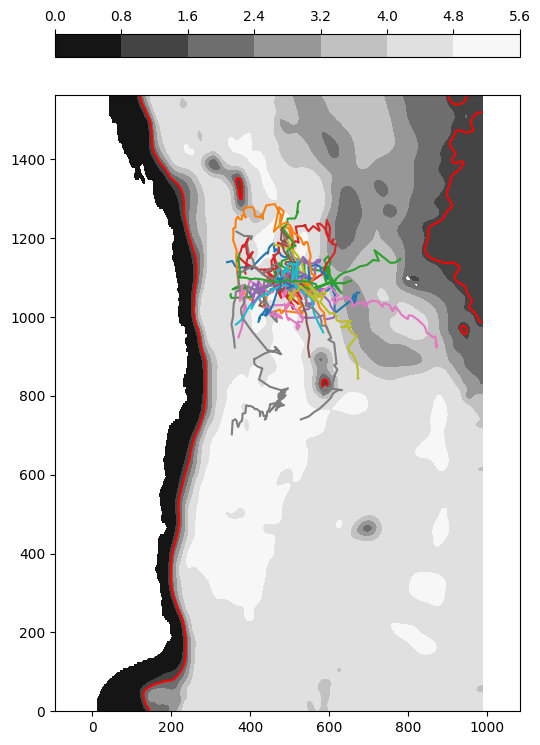

In [31]:
plt.figure(figsize=(6,10))
plt.contourf(X_grid, Y_grid, np.where(mask_rho, h/1e3, np.nan), cmap='Greys_r')
plt.colorbar(location='top')
plt.contour(X_grid, Y_grid, h/1e3, levels=[1.5], colors='r')

# Knoll
xk, yk = (500, 530), (1070, 1100)
xs = [xk[0], xk[1], xk[1], xk[0], xk[0]]
ys = [yk[0], yk[0], yk[1], yk[1], yk[0]]
plt.plot(xs, ys, c='m')

df_knoll_eddies = df_eddies[(df_eddies.xc>=xk[0])&(df_eddies.xc<=xk[1])&(df_eddies.yc>=yk[0])&(df_eddies.yc<=yk[1])]
knoll_eddies = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if np.any((df.xc>=xk[0])&(df.xc<=xk[1])&(df.yc>=yk[0])&(df.yc<=yk[1])):
        knoll_eddies.append(eddy)
df_knoll_eddies = df_eddies[df_eddies.Eddy.isin(knoll_eddies)]
    
for eddy in df_knoll_eddies.Eddy.unique():
    df = df_knoll_eddies[df_knoll_eddies.Eddy==eddy]
    plt.plot(df.xc, df.yc)

plt.axis('equal')



In [ ]:
/srv/scratch/z5297792/Chapter2/Knoll_Images

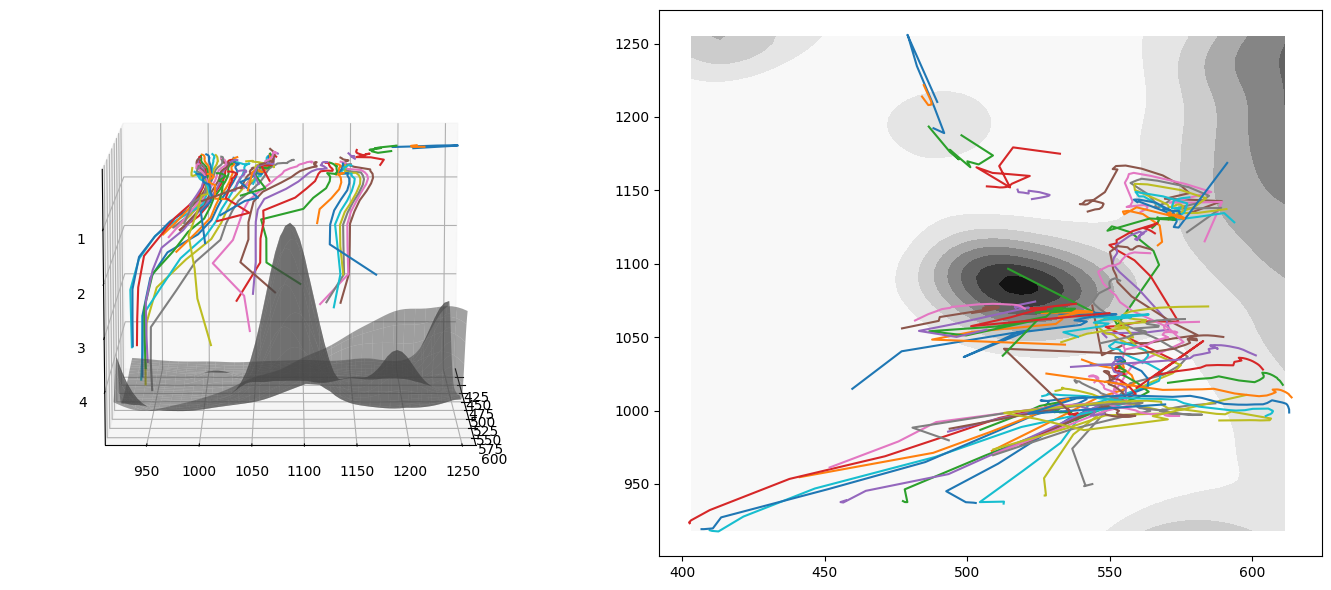

In [94]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,6))

# -----------------------
# 1) LEFT PANEL: 3-D plot
# -----------------------
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

k = 4
df_eddy = df_knoll_eddies[df_knoll_eddies.Eddy == df_knoll_eddies.Eddy.unique()[k]]

xmin, xmax = np.inf, -np.inf
ymin, ymax = np.inf, -np.inf

for day in df_eddy.Day:
    df = dic_eddies_vert[f'Eddy{df_eddy.Eddy.iloc[0]}'][f'Day{day}']
    ax1.plot(df.x, df.y, -df.Depth/1e3)
    xmin, xmax = min(xmin, df.x.min()), max(xmax, df.x.max())
    ymin, ymax = min(ymin, df.y.min()), max(ymax, df.y.max())

ax1.invert_zaxis()
ax1.view_init(elev=10, azim=0)

iy = (x_grid >= xmin) & (x_grid <= xmax)
ix = (y_grid >= ymin) & (y_grid <= ymax)

X_sub = X_grid[np.ix_(iy, ix)]
Y_sub = Y_grid[np.ix_(iy, ix)]
h_sub = h[np.ix_(iy, ix)]

ax1.plot_surface(X_sub, Y_sub, h_sub/1e3, alpha=.5)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)


# ------------------------
# 2) RIGHT PANEL: 2-D plot
# ------------------------
ax2 = fig.add_subplot(1, 2, 2)

ax2.contourf(X_sub, Y_sub, h_sub, cmap='Greys_r')

for day in df_eddy.Day:
    df = dic_eddies_vert[f'Eddy{df_eddy.Eddy.iloc[0]}'][f'Day{day}']
    ax2.plot(df.x, df.y)

plt.tight_layout()
